In [1]:
!pip3 install beautifulsoup4 --user
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install pyproj==1.9.6 --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [26]:
import os
import re
import shutil
import multiprocessing
import datetime
from datetime import date, timedelta

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

# Fetch observations

In [2]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(["script", "style"]):
            script.extract()
        return soup
    except Exception:
        return None

def get_stations_noaa():
    soup = fetch('https://tgftp.nws.noaa.gov/data/observations/metar/stations/')
    stations = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if 'TXT' in href:
            stations.append(href.split('.TXT')[0])
    return stations

def get_stations_with_coords():
    soup = fetch('http://weather.rap.ucar.edu/surface/stations.txt')
    text = soup.get_text()
    matches = re.findall(r".*([A-Z]{4}).*[\s]([\d]+\s[\d]+\w).*[\s]([\d]+\s[\d]+\w)[\s]*(\d{1,4}).*", text)
    stations = []
    for match in matches:
        stations.append({'ICAO': match[0], 'coords': "+".join(match[1:]).replace(' ', '-')})
    return stations

def gms_to_lat_lng(gms):
    comp = gms.split('-')
    if len(comp)==2:
        if 'N' in comp[1] or 'E' in comp[1]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)
        else:
            return -(int(comp[0])+(int(comp[1][:len(comp)])/60))
    elif len(comp)==3:
        if 'N' in comp[2] or 'E' in comp[2]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)+(int(comp[2][:len(comp)-1])/60)
        else:
            comp[2]='0'+comp[2][:len(comp)-1]
            return (-int(comp[0])-(int(comp[1][:len(comp)])/60)-(int(comp[2][:len(comp)-1])/3600))
    else:
        return 0

def get_last_metar(station):
    now = datetime.datetime.utcnow()
    soup = fetch(f"https://www.ogimet.com/display_metars2.php?lugar={station['ICAO']}&tipo=SA&ord=DIR&nil=NO&fmt=text&ano={now.year}&mes={now.month}&day={now.day}&hora={now.hour}")
    if soup is None:
        return []
    text = soup.get_text()
    if f"No hay METAR/SPECI de {station} en el periodo solicitado" in text:
        return []
    data = []
    text = re.sub('\s\s+', ' ', text)
    matches = re.findall(r"\s(\d+)[\s]METAR\s(.*)=", text)
    for match in matches:
        if ',' not in match:
            (lat, lng, elev) = station['coords'].split('+')
            data.append({ 'lat': gms_to_lat_lng(lat), 'lng': gms_to_lat_lng(lng), 'elev': elev, 'datetime': match[0], 'observation': match[1] })
    return data

# Parse data from METAR

In [3]:
PRESSURE_LEVELS_HEIGHTS_VALUES = [
    762,
    1458,
    3013,
    5576,
    9166,
    11787,
    16000,
]

def get_pressure(obs):
    """returns press Pa
    
    format examples:
        pressure: 1027.8 mb
        3-hr pressure change 1.7hPa, increasing, then decreasing
    """

    press = 0.0
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0])
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0])

    return press * 100

def get_dew_point(obs):
    """ returns temp K """
    return float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def get_temperature(obs):
    """ returns temp K """
    return float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)

def get_wind_comps(obs):
    # ESE at 11 knots
    # WSW at greater than 99 knots
    if 'knots' in obs and 'variable' not in obs:
        compass_point, mag = re.findall(r".*wind:\s(\w+)[\s|\w]*[\s]([0-9]+)[\s]knots", obs)[0]
        ang = portolan.middle(compass_point)
        # print(f"get_wind_comps, compass_point:{compass_point} mag:{mag}\n")
        mag = int(mag) / 1.944
        u = mag * np.sin(ang)
        v = mag * np.cos(ang)
        return (u, v)
    else:
        return (0, 0)

def elev_to_press_level(elev):
    max_diff = 10000
    level = 0
    for (idx, val) in enumerate(PRESSURE_LEVELS_HEIGHTS_VALUES):
        diff = abs(val - elev)
        if max_diff > diff:
            level = idx
            max_diff = diff
    return level

# Physical formulas

In [4]:
def vapor_pressure(T):
    """Return partial water vapor pressure (e) or saturation vapor pressure (es) hPa.
    
    dew_point for (e) K
    temperature for (es) K
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    alternatives: August–Roche–Magnus formula
    """
    a = 17.2693882
    b = 35.86
    e = 6.1078 * np.exp(a * (T - 273.16) / (T - b))
    
    return e

def calculate_shum(dew_point, pressure):
    """Return specific humidity kg/kg.
    
    dew_point K
    pressure  Pa
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    """
    e = vapor_pressure(dew_point)
    q = 0.622 * e  / (pressure - 0.378 * e)
    
    #print(dew_point, pressure, q)    
    return q

def calculate_rhum(dew_point, temp):
    """ validator: https://www.wpc.ncep.noaa.gov/html/dewrh.shtml """
    rhum = 100 * vapor_pressure(dew_point) / vapor_pressure(temp)

    #print(dew_point, temp, rhum)
    return rhum

In [5]:
noaa_stations = get_stations_with_coords()
print(len(noaa_stations))

9580


In [6]:
line = 'KHRL 112152Z 10011KT 10SM FEW036 BKN060 28/21 A2984 RMK AO2 SLP105 T02780206'
obs = Metar.Metar(line).string()
print(obs)

dew_point = get_dew_point(obs)
temp = get_temperature(obs)
press = get_pressure(obs)
(u, v) = get_wind_comps(obs)

calculate_rhum(dew_point, temp)
calculate_shum(dew_point, press)

station: KHRL
type: routine report, cycle 22 (automatic report)
time: Wed Nov 11 21:52:00 2020
temperature: 27.8 C
dew point: 20.6 C
wind: E at 11 knots
visibility: 10 miles
pressure: 1010.5 mb
sky: a few clouds at 3600 feet
     broken clouds at 6000 feet
sea-level pressure: 1010.5 mb
remarks:
- Automated station (type 2)
METAR: KHRL 112152Z 10011KT 10SM FEW036 BKN060 28/21 A2984 RMK AO2 SLP105 T02780206


0.0001492725956726276

# Multiprocessing METARs fetching

In [7]:
def fetch_last_metars(station):
    localdata = []
    metar_obs = get_last_metar(station)
    for obs_item in metar_obs:
        hour = datetime.datetime.strptime(obs_item['datetime'], '%Y%m%d%H%M').hour
        localdata.append([obs_item['lat'], obs_item['lng'], obs_item['elev'], obs_item['datetime'], obs_item['observation']])
    return localdata

In [8]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(fetch_last_metars, noaa_stations)
    
df = []
for elem in data:
    for arr in elem:
        df.append(arr)

len(df)

1344

In [9]:
df = pd.DataFrame(data=df, columns=['lat', 'lng', 'elev', 'datetime', 'observation'])
df.head(5)

,lat,lng,elev,datetime,observation
0,61.866667,-162.033333,31,202011192102,PADM 192102Z AUTO 07027G31KT 10SM OVC041 M06/M...
1,63.016667,-154.350000,126,202011192101,PAFS 192101Z AUTO 00000KT 8SM CLR M26/M29 A297...
2,32.466667,-87.950000,34,202011192115,KDYA 192115Z AUTO 11005KT 10SM CLR 21/M01 A304...
3,29.233333,-87.783333,53,202011192100,KVOA 192100Z AUTO 08021G27KT 7SM 23/17 A3034 R...
4,28.800000,-82.316667,15,202011192115,KINF 192115Z AUTO 05012G18KT 7SM CLR 22/16 A30...


In [10]:
idx = 0
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)
print(row['lat'], row['lng'], row['elev'])

station: PADM
type: routine report, cycle 21 (automatic report)
time: Thu Nov 19 21:02:00 2020
temperature: -6.1 C
dew point: -8.9 C
wind: ENE at 27 knots, gusting to 31 knots
peak wind: E at 33 knots at 20:05
visibility: 10 miles
pressure: 996.3 mb
sky: overcast at 4100 feet
remarks:
- Automated station (type 2)
- peak wind 33kt from 80 degrees at 20:05
- SLPNO 6//// FZRANO
METAR: PADM 192102Z AUTO 07027G31KT 10SM OVC041 M06/M09 A2942 RMK AO2 PK WND 08033/2005 SLPNO 6//// T10611089 FZRANO
61.86666666666667 -162.03333333333333 31


In [11]:
df['datetime'] = pd.to_datetime(df.datetime)
df = df.sort_values(by='datetime')

df.head()

,lat,lng,elev,datetime,observation
671,48.966667,2.450000,65,2020-11-19 21:00:00,LFPB 192100Z AUTO 32004KT 280V350 9999 SCT033 ...
900,18.300000,42.783333,2054,2020-11-19 21:00:00,OEKM 192100Z 00000KT CAVOK 14/12 Q1024 NOSIG
899,24.066667,47.583333,503,2020-11-19 21:00:00,OEKJ 192100Z 13010KT CAVOK 19/09 Q1021
898,21.683333,39.150000,15,2020-11-19 21:00:00,OEJN 192100Z 36002KT 9999 BKN035 29/23 Q1010 N...
897,27.050000,49.383333,8,2020-11-19 21:00:00,OEJB 192100Z AUTO 22002KT CAVOK 19/15 Q1016 NOSIG


In [12]:
def parse_metars(idx):
    dt = []
    cords = []
    row = df.iloc[idx]
    try:
        temp = 0.0
        obs = Metar.Metar(row['observation']).string()
        if ('temperature' in obs):
            temp = get_temperature(obs)
            if temp < 331.15:
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'air', temp])

        (u, v) = get_wind_comps(obs)
        if (u, v) != (0,0):
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'uwnd', u])
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'vwnd', v])

        if ('pressure' in obs):
            press = get_pressure(obs)
            if press < 105100 and press > 52200:
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'press', press])

        if ('dew point' in obs and 'pressure' in obs):
            dew_point = get_dew_point(obs)
            if dew_point > 0 and press < 105100 and press > 52200 and dew_point <= temp and temp != 0 :
                shum = calculate_shum(dew_point, press)
                rhum = calculate_rhum(dew_point, temp)
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'rhum', rhum])
                if shum < 0.05:
                    dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'shum', shum])

        cords.append((row['lat'], row['lng']))
    except Exception as e:
        str_err = str(e)
        if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
            print('index:', idx, 'error:', e)
    return (dt, cords)

In [13]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(parse_metars, range(len(df)))
    
df_parsed_metars = []
active_stations = []
for elem in data:
    df_parsed_metars += elem[0]
    for cords in elem[1]:
        if (cords not in active_stations):
            active_stations.append(cords)

print(f"total metars: {len(df_parsed_metars)}, active stations: {len(active_stations)}")

total metars: 7377, active stations: 1306


In [14]:
df_metar_info = pd.DataFrame(df_parsed_metars,columns=['datetime','lat','lng','elev','variable','value'])

df_metar_info.head(10)

,datetime,lat,lng,elev,variable,value
0,2020-11-19 21:00:00,48.966667,2.450000,65,air,281.150000
1,2020-11-19 21:00:00,48.966667,2.450000,65,uwnd,-0.362234
2,2020-11-19 21:00:00,48.966667,2.450000,65,vwnd,2.025477
3,2020-11-19 21:00:00,48.966667,2.450000,65,press,103300.000000
4,2020-11-19 21:00:00,48.966667,2.450000,65,rhum,93.389669
5,2020-11-19 21:00:00,48.966667,2.450000,65,shum,0.000060
6,2020-11-19 21:00:00,18.300000,42.783333,2054,air,287.150000
7,2020-11-19 21:00:00,18.300000,42.783333,2054,press,102400.000000
8,2020-11-19 21:00:00,18.300000,42.783333,2054,rhum,87.736235
9,2020-11-19 21:00:00,18.300000,42.783333,2054,shum,0.000085


In [15]:
all_df_datetimes = []

for df_datetime in df_metar_info.datetime.unique():
    parsed_datetime = datetime.datetime.strptime(df_datetime, '%Y-%m-%d %H:%M:%S')
    if parsed_datetime.minute == 0:
        all_df_datetimes.append(parsed_datetime)

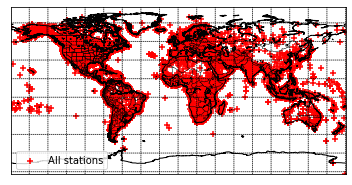

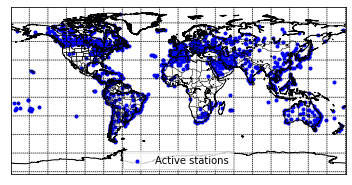

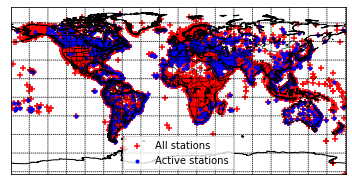

In [16]:
lati = []
lngt = []
lati2 = []
lngt2 = []
dataexport=[]
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    lati.append(gms_to_lat_lng(lat))
    lngt.append(gms_to_lat_lng(lng))
    nombreEstacion=station['ICAO']
    dataexport.append([nombreEstacion,gms_to_lat_lng(lat),gms_to_lat_lng(lng),elev])

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('last/all_stations.jpg', dpi=600)
plt.show()

for station in active_stations:
    row = df.iloc[idx]
    lati2.append(station[0])
    lngt2.append(station[1])
    
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('last/active_stations.jpg', dpi=600)
plt.show()

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('last/all_stations_vs_active_stations.jpg', dpi=600)
plt.show()

count    1292.000000
mean        0.000076
std         0.000056
min         0.000001
25%         0.000034
50%         0.000057
75%         0.000105
max         0.000220
Name: value, dtype: float64

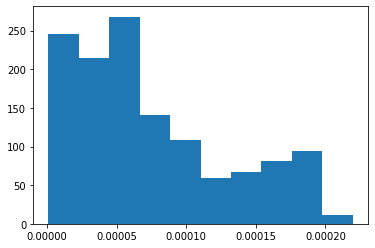

In [17]:
data = df_metar_info.loc[df_metar_info['variable']=='shum']['value']
plt.hist(data)
data.describe()

count    1292.000000
mean       73.768437
std        18.472090
min         5.950391
25%        63.389874
50%        77.708384
75%        87.167283
max       100.000000
Name: value, dtype: float64

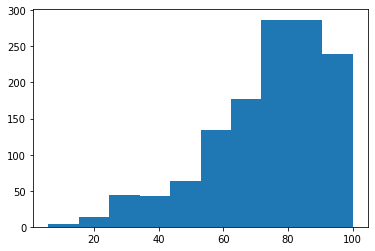

In [18]:
data = df_metar_info.loc[df_metar_info['variable']=='rhum']['value']
plt.hist(data)
data.describe()

count      1298.000000
mean     101851.171032
std         941.764130
min       97000.000000
25%      101190.000000
50%      101700.000000
75%      102400.000000
max      104500.000000
Name: value, dtype: float64

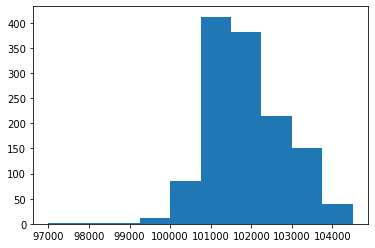

In [19]:
data = df_metar_info.loc[df_metar_info['variable']=='press']['value']
plt.hist(data)
data.describe()

count    1303.000000
mean      284.164198
std        13.556122
min       236.150000
25%       276.150000
50%       286.150000
75%       296.150000
max       308.150000
Name: value, dtype: float64

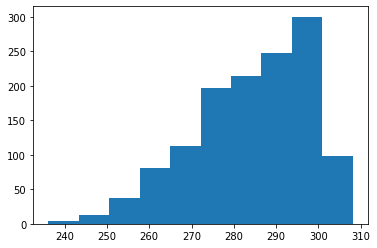

In [20]:
data = df_metar_info.loc[df_metar_info['variable']=='air']['value']
plt.hist(data)
data.describe()

count    1096.000000
mean       -0.074213
std         3.585937
min       -13.875298
25%        -2.025252
50%        -0.181117
75%         2.039516
max        14.276612
Name: value, dtype: float64

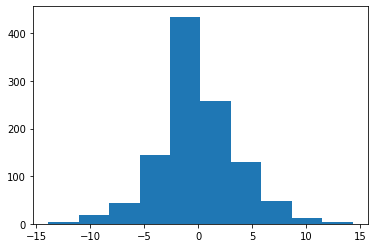

In [21]:
data = df_metar_info.loc[df_metar_info['variable']=='uwnd']['value']
plt.hist(data)
data.describe()

count    1096.000000
mean        0.337332
std         3.409990
min       -11.272599
25%        -1.945330
50%         0.476521
75%         2.348094
max        13.165602
Name: value, dtype: float64

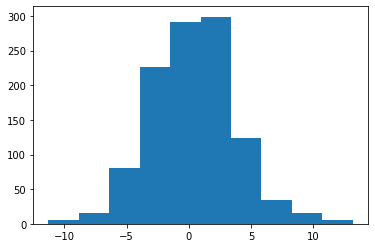

In [22]:
data = df_metar_info.loc[df_metar_info['variable']=='vwnd']['value']
plt.hist(data)
data.describe()

In [23]:
def create_csv(file_datetime):
    filename = "last/{}.csv".format(file_datetime.strftime('%Y%m%d%H'))
    df_file = df_metar_info.loc[df_metar_info['datetime'].str.contains(file_datetime.strftime('%Y-%m-%d %H'))]
    df_file.to_csv(filename, index=False)

In [27]:
path = os.path.abspath(os.getcwd())
shutil.rmtree(f"{path}/last")
os.mkdir(f"{path}/last")

In [28]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(create_csv, all_df_datetimes)